# Deep Reinforcement Learning for skeleton-based action recognition
Bahareh Nikpour <br>email: bahareh.nikpour@mail.mcgill.ca <br>
<br>Farzaneh Entezari <br>email: farzaneh.entezari@mail.mcgill.ca <br>

##**Read me**
To run this code, please download the data from the following link:<br> https://drive.google.com/open?id=1CZrSrpnWLbCTseQ2VrOiax1qE6nfGkG0 and store the "RL_project_data" in your drive. <br>
This link contains 20 .csv files and in each of them, there exist 10 actions done by a person. The first column of each file is the corresponding action's label.<br> 
* To read and process the data, please run the **Data reading** section.<br>
* To visualize frames, please run **visualizing two frames from data samples** sub-section. You can change,
frame_1=200, frame_2=50, x=1 tp see frames of different actions done by different people respectively. 
* To train CNN (to be used in FDNET), please run the section **CNN network which is used as the pre-trained classifier in the policy gradient**. The following subsection gives the test accuracy before frame selection.
* To train the policy gradient and test it, please run the section **policy gradient (Reinforce) for frame selection**

##**Data reading**
The data we used is the skeleton recordings of UT kinect data set. This data contain 10 classes (actions) as:<br>
1- walk $\: \:\: \:\: \:$ 2- sitDown:  $\: \:\: \:\: \:$ 3- standUp $\: \:\: \:\: \:$
4- pickUp $\: \:\: \:\: \:$
5- carry $\: \:\: \:\: \:$
6- throw $\: \:\: \:\: \:$
7- push $\: \:\: \:\: \:$
8- pull $\: \:\: \:\: \:$
9- waveHands$\: \:\: \:\: \:$
10- clapHands $\: \:\: \:\: \:$


In each frame, the coordinate of 20 joints are recorded. The joints are:<br>
1- head --> 3 $\: \:\: \:\: \:$ 2- shoulder center --> 2 $\: \:\: \:\: \:$ 3- left shoulder --> 4 $\: \:\: \:\: \:$
4- right shoulder --> 8 <br>
5- left elbow --> 5 $\: \:\: \:\: \:$
6- right elbow --> 9 $\: \:\: \:\: \:$
7- left wrist --> 6 $\: \:\: \:\: \:$
8- right wrist--> 10 <br>
9- left hand --> 7$\: \:\: \:\: \:$
10- right hand --> 11 $\: \:\: \:\: \:$
11- spine --> 1 $\: \:\: \:\: \:$
12- hip center--> 0 <br>
13- left hip --> 12 $\: \:\: \:\: \:$
14- right hip --> 16 $\: \:\: \:\: \:$
15- left knee --> 13 $\: \:\: \:\: \:$
16- right knee --> 17 <br>
17- left ankle --> 14 $\: \:\: \:\: \:$
18- right ankle --> 18 $\: \:\: \:\: \:$
9- left foot --> 15 $\: \:\: \:\: \:$
20- right foot --> 19 <br>


Our goal is to select key frames for recognizing these actions. To read the data, drag and drop 1 to 20 .csv files and run the following code. The code below preprocesses the data i.e. build the graphs and specify labels, etc.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/RL_project_data")
!pwd

/content/gdrive/My Drive/RL_project_data


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from numpy.random import default_rng



joints_num=20
beta=1
alpha=5
connections=np.array([[0,1],[1,0],[14,15],[15,14],[13,14],
                      [14,13],[18,19],[19,18],[17,18],[18,17],
                      [12,13],[13,12],[16,17],[17,16],[12,0],[0,12],
                      [16,0],[0,16],[2,4],[4,2],[8,2],[2,8],[1,2],[2,1],
                      [2,3],[3,2],[4,5],[5,4],[5,6],[6,5],[6,7],[7,6],
                      [9,8],[8,9],[9,10],[10,9],[11,10],[10,11]])


def build_graph(connections,joints_num,beta,alpha,data):
  f_x=[]
  f_y=[]
  f_z=[]
  for i in range(len(data)):
    if (i+1)%3==1:
      f_x.append(data[i])
    elif (i+1)%3==2:
      f_y.append(data[i])
    else: 
      f_z.append(data[i])
  x=np.vstack((f_x, f_y, f_z))
  Adjacancy=beta*np.ones([joints_num,joints_num])
  size=np.shape(connections)
  for i in range(joints_num):
    for j in range(joints_num):
      if i==j:
        Adjacancy[i,j]=0
  for k in range(size[0]):
    indexes=connections[k,:]
    Adjacancy[indexes[0],indexes[1]]=alpha
  return Adjacancy, np.double(x.T)

F=30  #N of all frames                    #graph_size
M=15 

l1=[]
l2=[]
llabels=[]
ind_M=[]
for x in range(1,19): 
  f =pd.read_csv('%d.csv' % x)
  f=f.values
  sz=np.shape(f)
  labels=f[:,0]
  f=f[:,1:62]
  f_i=np.arange(sz[0])
  for i in range(10):
    ind=np.where(labels==i+1)
    ind=ind[0]
    if len(ind)>=F:
      llabels.append(i)
      rng = default_rng()
      numbers = rng.choice(50, size=30, replace=False)
      ind_f=ind[np.sort(rng.choice(len(ind),size=F,replace=False))]
      MM=np.sort(rng.choice(len(ind_f), size=M,replace=False))
      ind_m=ind_f[MM] ## ind_m and ind_M are different ????
      # ind_f=ind[0:F]
      # ind_m=ind[0:M]
      ind_M.append(MM) ## selected indices ##TODO: one hot vector
      var1=[]
      var2=[] 
      for j in range(F):
        A,x1=build_graph(connections,joints_num,beta,alpha,f[ind_f[j],:])
        x1=torch.from_numpy(x1)
        var1.append(x1) ## reads all frames that have label=1
      for k in range(M):
        A,x2=build_graph(connections,joints_num,beta,alpha,f[ind_m[k],:])
        x2=torch.from_numpy(x2)
        var2.append(x2)
      l1.append(torch.stack(var1))  ## all the datas F frames each
      l2.append(torch.stack(var2))  ## all the datas M frames each

labelss=np.array(llabels)
labelss[labelss>1]=0
labelss=torch.tensor(labelss,dtype=torch.long)
num_samples=10
x_f=torch.stack(l1)  ## convert to tensor format number of samples*F*20*3 shape
x_m=torch.stack(l2)

def create_Sb(ind_M,F):
  S_b=np.zeros([np.shape(ind_M)[0],F])
  for t in range(np.shape(ind_M)[0]):
    S_b[t,ind_M[t]]=1
  return S_b
S_b=create_Sb(ind_M,F)


def create_Sa(x_f,x_m,F):
  """   Args:
        x_f: a original video frames
        x_m: a selected video frames
        
        Returns:
        S_a: a part of the state
         """
  S_a=[]
  for i in range(np.shape(x_f)[0]):
    Ss_a=[]
    for j in range(np.shape(x_f)[1]+np.shape(x_m)[1]):
      if j<F:
        Ss_a.append(x_f[i,j,:,:])
      else:
        Ss_a.append(x_f[i,F-j,:,:])
    S_a.append(torch.stack(Ss_a))
  return torch.stack(S_a)
S_a=create_Sa(x_f,x_m,F)
data=x_f

###**visualizing two frames from data samples**
Two frames from two classes "throw" and "sit down" are plotted.

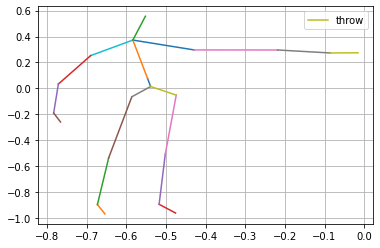

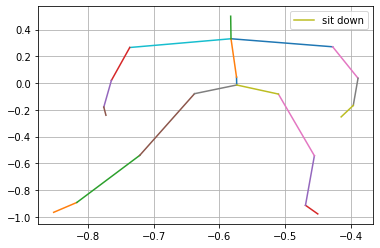

In [ ]:
frame_1=200
frame_2=50
x=1
f =pd.read_csv('%d.csv' % x)
f=f.values
sz=np.shape(f)
one_f1=f[frame_1,1:62]
one_f2=f[frame_2,1:62]
labels=f[:,0]
f_x=np.zeros([20])
f_y=np.zeros([20])
f_z=np.zeros([20])
x=0
y=0
z=0
for i in range(len(one_f1)):
  if (i+1)%3==1:
    f_x[x]=one_f1[i]
    x+=1
  elif (i+1)%3==2:
    f_y[y]=one_f1[i]
    y+=1
  else: 
    f_z[z]=one_f1[i]
    z+=1

import matplotlib.pyplot as plt
plt.plot(f_x[[0,1]],f_y[[0,1]])
plt.plot(f_x[[15,14]],f_y[[15,14]])
plt.plot(f_x[[13,14]],f_y[[13,14]])
plt.plot(f_x[[18,19]],f_y[[18,19]])
plt.plot(f_x[[17,18]],f_y[[17,18]])
plt.plot(f_x[[12,13]],f_y[[12,13]])
plt.plot(f_x[[16,17]],f_y[[16,17]])
plt.plot(f_x[[12,0]],f_y[[12,0]])
plt.plot(f_x[[16,0]],f_y[[16,0]])
plt.plot(f_x[[2,4]],f_y[[2,4]])
plt.plot(f_x[[8,2]],f_y[[8,2]])
plt.plot(f_x[[1,2]],f_y[[1,2]])
plt.plot(f_x[[2,3]],f_y[[2,3]])
plt.plot(f_x[[4,5]],f_y[[4,5]])
plt.plot(f_x[[5,6]],f_y[[5,6]])
plt.plot(f_x[[6,7]],f_y[[6,7]])
plt.plot(f_x[[9,8]],f_y[[9,8]])
plt.plot(f_x[[9,10]],f_y[[9,10]])
plt.plot(f_x[[11,10]],f_y[[11,10]],label='throw')
plt.grid()
plt.legend()

plt.show()

f_x=np.zeros([20])
f_y=np.zeros([20])
f_z=np.zeros([20])
x=0
y=0
z=0
for i in range(len(one_f2)):
  if (i+1)%3==1:
    f_x[x]=one_f2[i]
    x+=1
  elif (i+1)%3==2:
    f_y[y]=one_f2[i]
    y+=1
  else: 
    f_z[z]=one_f2[i]
    z+=1

import matplotlib.pyplot as plt
plt.plot(f_x[[0,1]],f_y[[0,1]])
plt.plot(f_x[[15,14]],f_y[[15,14]])
plt.plot(f_x[[13,14]],f_y[[13,14]])
plt.plot(f_x[[18,19]],f_y[[18,19]])
plt.plot(f_x[[17,18]],f_y[[17,18]])
plt.plot(f_x[[12,13]],f_y[[12,13]])
plt.plot(f_x[[16,17]],f_y[[16,17]])
plt.plot(f_x[[12,0]],f_y[[12,0]])
plt.plot(f_x[[16,0]],f_y[[16,0]])
plt.plot(f_x[[2,4]],f_y[[2,4]])
plt.plot(f_x[[8,2]],f_y[[8,2]])
plt.plot(f_x[[1,2]],f_y[[1,2]])
plt.plot(f_x[[2,3]],f_y[[2,3]])
plt.plot(f_x[[4,5]],f_y[[4,5]])
plt.plot(f_x[[5,6]],f_y[[5,6]])
plt.plot(f_x[[6,7]],f_y[[6,7]])
plt.plot(f_x[[9,8]],f_y[[9,8]])
plt.plot(f_x[[9,10]],f_y[[9,10]])
plt.plot(f_x[[11,10]],f_y[[11,10]],label='sit down')
plt.grid()
plt.legend()

##**CNN network which is used as the pre-trained classifier in the policy gradient**
The network is given the data frames with labels to be trained.

In [ ]:
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

data_x = x_f.reshape(S_a.shape[0], 3, F, 20)
perm_ind=np.random.permutation(data_x.shape[0])
train_ind=perm_ind[0:int(np.ceil(np.shape(perm_ind)[0]*0.7))]
test_ind=perm_ind[int(np.ceil(np.shape(perm_ind)[0]*0.7)):np.shape(perm_ind)[0]]
train_x=data_x[list(train_ind)]
test_x=data_x[list(test_ind)]
llabels =  torch.tensor(llabels,dtype=torch.long)
train_labels=llabels[list(train_ind)]
test_labels=llabels[list(test_ind)]
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=3),
            # BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, padding=1),
            # BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2),

            Conv2d(64, 128, kernel_size=3, padding=1),
            # BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2),
        )

        self.linear_layers = Sequential(
            Linear(768, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)


def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_labels)
    # getting the validation set
    x_val, y_val = Variable(test_x), Variable(test_labels)


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(train_x)
    output_val = model(test_x)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_train)

# defining the number of epochs
n_epochs = 1000
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
train_accuracy=[]
for epoch in range(n_epochs):
    train(epoch)

# plotting the training and validation loss


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=768, out_features=10, bias=True)
  )
)
Epoch :  1 	 loss : tensor(2.3300, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(1.9411, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.8962, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.8743, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.8226, grad_fn=<NllLossBackward>)
Epoch :  1

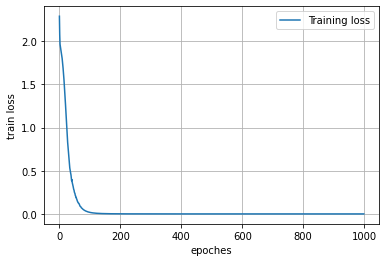

In [ ]:
plt.plot(train_losses, label='Training loss')
# plt.plot(train_accuracy, label='Validation loss')
plt.legend()
plt.xlabel('epoches')
plt.ylabel('train loss')
plt.grid()

###**Test accuracy before frame selection**

In [ ]:
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
np.sum((test_labels.numpy())==predictions)/len(predictions)*100

91.66666666666666

##**Policy gradient (Reinforce) for frame selection**

In [ ]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

gamma = 0.7

#policy network with one hidden layer

class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),)

        self.linear_layers = Sequential(
            Linear(7680,2))
        optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy()))
        log_pr = torch.log(pr.squeeze(0)[act])
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class):
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 3 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10

  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    reward = np.sign( Probs[true_class -1 ]  - Probs_history[true_class -1 ]) ## -1 is bcz classes are from 1 to 10

  return reward   
x_main=x_f
def train(x,labels):
    
    # S_a = create_Sa(x_f,x_m,F)
    n_states=30
    n_actions=2
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128)
    
    max_episode_num = 500
    max_steps = 30
    numsteps = []
    avg_numsteps = []
    all_rewards = []
    x_trnew=[]
    label_new=[]
    final_ind=[]
    for episode in range(max_episode_num):
      rewards2=[]
      for v in range(np.shape(x)[0]):
        log_probs = []
        rewards = []
        x_tr=[]
        index_one_hot=np.ones([30])
        Action=[]
        XX=x[v]
        original_fr=XX.clone().detach()
        original_label=labels.numpy()[v]
        for steps in range(max_steps):
            state = original_fr[steps]
            state=state.reshape(1,1,20,3)
            action, log_prob = policy_net.select_action(state)
            Action.append(action)
            index_one_hot[steps]=action
            ind_MM1=np.where(index_one_hot==0)
            ind_MM1=ind_MM1[0]
            xm1=original_fr
            xm1[ind_MM1]=0
            xmm=xm1
            xm1=xm1.reshape(1, 3, 30, 20)
            original_fr=XX
            with torch.no_grad():
              output = model(xm1)
            softmax = torch.exp(output)
            prob = list(softmax.numpy())
            prediction = np.argmax(prob, axis=1)
            prob=prob[0]
            if (steps == 0):
              reward = 1 if prediction==original_label else -1
            else:
              reward=calculate_reward(prob, Probs_history ,original_label)
            Probs_history=prob
            log_probs.append(log_prob)
            rewards.append(reward)
        if episode==max_episode_num-1:
          final_ind.append(Action)

        rewards2.append(np.mean(rewards))
        update_policy(policy_net, rewards, log_probs)
        x_tr.append(xmm)
        label_new.append(original_label)
      R=np.sum((rewards2))
      x_trnew.append(torch.cat(x_tr))
      all_rewards.append(R)
        
            


        
    return all_rewards,final_ind

In [ ]:
llabels =  torch.tensor(llabels,dtype=torch.long)
all_rewards,final_ind=train(x_main,llabels)

Text(0, 0.5, 'the average reward')

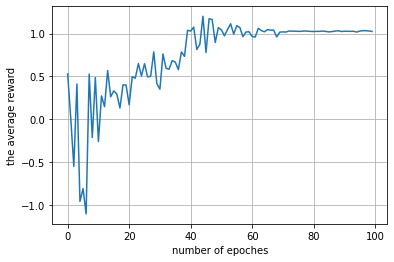

In [ ]:
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.grid()


###**Average number of selected frame in all videos**

In [ ]:
np.sum(final_ind)/81

14.82716049382716

###**Test accuracy after frame selection**

In [ ]:

final_ind=np.array(final_ind)
llabels =  torch.tensor(llabels,dtype=torch.long)
final_d=[]
for i in range(final_ind.shape[0]):
  ind=final_ind[i]
  d=data[i]
  d[ind]=0
  final_d.append(d)
final_d=torch.stack(final_d)


data_x = final_d.reshape(S_a.shape[0], 3, 30, 20)
perm_ind=np.random.permutation(data_x.shape[0])
train_ind=perm_ind[0:int(np.ceil(np.shape(perm_ind)[0]*0.7))]
test_ind=perm_ind[int(np.ceil(np.shape(perm_ind)[0]*0.7)):np.shape(perm_ind)[0]]
train_x=data_x[list(train_ind)]
test_x=data_x[list(test_ind)]
train_labels=labelss[list(train_ind)]
test_labels=labelss[list(test_ind)]
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_labels)
    # getting the validation set
    x_val, y_val = Variable(test_x), Variable(test_labels)


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(train_x)
    output_val = model(test_x)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    # if epoch%2 == 0:
        # printing the validation loss
        # print('Epoch : ',epoch+1, '\t', 'loss :', loss_train)

# defining the number of epochs
n_epochs = 500
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
train_accuracy=[]
for epoch in range(n_epochs):
    train(epoch)



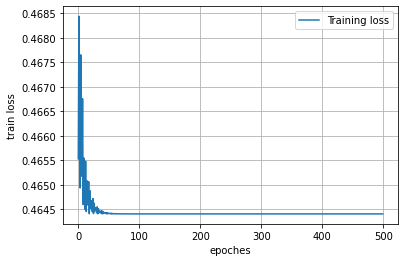

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
# plt.plot(train_accuracy, label='Validation loss')
plt.legend()
plt.xlabel('epoches')
plt.ylabel('train loss')
plt.grid()


In [ ]:
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
np.sum((test_labels.numpy())==predictions)/len(predictions)*100

95.83333333333334